## Import Dependencies

In [1]:
import numpy as np
import pandas as pd

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

import networkx as nx
import gurobipy as gp
from gurobipy import GRB

import time

import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

from scipy.linalg import eigh


In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from itertools import combinations

In [3]:
import warnings
warnings.filterwarnings('ignore')

## GCS-Q Algorithm

In [ ]:
# Step 1: Construct the initial graph from the adjacency matrix
def construct_graph(adj_matrix):
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    return G

# Step 2: Define the function to calculate coalition value (sum of weights)
def coalition_value(subgraph):
    return subgraph.size(weight='weight')


def get_qubo_matrix(W):
    """Computes the QUBO matrix for the Minimum Cut problem given a weight matrix W."""
    n = W.shape[0]  # Number of nodes
    Q = np.zeros((n, n))  # Initialize QUBO matrix
    for i in range(n):
        Q[i, i] = np.sum(W[i])  # Diagonal terms (degree of node)
        for j in range(n):
            if i != j:
                Q[i, j] = -W[i, j]  # Off-diagonal terms (negative adjacency)
    return Q

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition(graph):
    if len(graph.nodes())==1:
       return [], [0], 0
    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)
    bqm = BinaryQuadraticModel.from_qubo(qubo)
    sampler = EmbeddingComposite(DWaveSampler(token = open('dwave-api-token.txt','r').read(), solver={'topology__type': 'pegasus'}))
    sampleset = sampler.sample(bqm, num_reads=1000)
    qpu_access_time = sampleset.info['timing']['qpu_access_time']
    solution = sampleset.first.sample
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]
    return partition1, partition2, qpu_access_time

def gurobi_qubo_solver(qubo_matrix):
    n = qubo_matrix.shape[0]
    model = gp.Model()
    x = model.addVars(n, vtype=GRB.BINARY)
    obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
    model.setObjective(obj_expr)
    model.setParam('OutputFlag', 0)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        solution = [int(x[i].X) for i in range(n)]
        binary_string = ''.join(str(bit) for bit in solution)
        return binary_string, model.objVal
    else:
        return None, None

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition_gurobi(graph):
    if len(graph.nodes())==1:
       return [], [0]
    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)
    solution_str, objective_value = gurobi_qubo_solver(qubo)
    solution = {idx:int(bit) for idx,bit in enumerate(solution_str)}
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]
    return partition1, partition2


# Step 4: Iterative GCS-Q Algorithm
def gcs_q_algorithm(adj_matrix, qubo_solver = "dwave"):
    G = construct_graph(adj_matrix)
    grand_coalition = list(G.nodes)
    queue = [grand_coalition]
    CS_star = []
    while queue:
        C = queue.pop(0)  # Dequeue the first coalition
        subgraph = G.subgraph(C).copy()
        # Solve the optimal split problem
        if qubo_solver == "dwave":
            partition1, partition2, qpu_access_time = bipartition(subgraph)
        else:
            partition1, partition2 = bipartition_gurobi(subgraph)
        partition1 = [C[subgraph_node_index] for subgraph_node_index in partition1]
        partition2 = [C[subgraph_node_index] for subgraph_node_index in partition2]
        if not partition2:  # If no meaningful split is found
            CS_star.append(partition1)
        elif not partition1:
            CS_star.append(partition2)
        else:  # If a meaningful split is found, enqueue the partitions
            queue.append(partition1)
            queue.append(partition2)
    return CS_star

## PAM Algorithm

In [ ]:
def calculate_total_cost(distance_matrix, medoids, clusters):
    total_cost = 0
    for medoid, cluster in zip(medoids, clusters):
        total_cost += np.sum(distance_matrix[cluster][:, medoid])
    return total_cost

def assign_clusters(distance_matrix, medoids):
    clusters = [[] for _ in range(len(medoids))]
    for i in range(distance_matrix.shape[0]):
        distances_to_medoids = [distance_matrix[i, medoid] for medoid in medoids]
        closest_medoid = np.argmin(distances_to_medoids)
        clusters[closest_medoid].append(i)
    return clusters

def pam(distance_matrix, k, max_iter=100):
    # Step 1: Initialize medoids
    medoids = np.random.choice(distance_matrix.shape[0], k, replace=False)
    best_medoids = medoids.copy()
    clusters = assign_clusters(distance_matrix, medoids)
    best_cost = calculate_total_cost(distance_matrix, medoids, clusters)
    
    for _ in range(max_iter):
        for medoid_idx in range(k):
            current_medoid = medoids[medoid_idx]
            non_medoids = [i for i in range(distance_matrix.shape[0]) if i not in medoids]
            
            for new_medoid in non_medoids:
                new_medoids = medoids.copy()
                new_medoids[medoid_idx] = new_medoid
                new_clusters = assign_clusters(distance_matrix, new_medoids)
                new_cost = calculate_total_cost(distance_matrix, new_medoids, new_clusters)
                
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_medoids = new_medoids.copy()
                    clusters = new_clusters
                    
        if np.array_equal(best_medoids, medoids):
            break
        else:
            medoids = best_medoids.copy()
    
    return best_medoids, clusters

def clusters_as_set_of_sets(clusters):
    return [cluster for cluster in clusters]



## SPONGE

In [9]:
from signet.cluster import Cluster 
from signet.block_models import SSBM
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import csc_matrix

In [ ]:
def sponge_clustering_wrapper(adj_matrix, k, method = 'SPONGE'):
    """
    Adapts the SPONGE/signet clustering approach to take an adjacency matrix 
    (e.g., a correlation matrix) and the number of clusters k as input,
    and returns the cluster compositions.

    Parameters:
    ----------
    adj_matrix : np.ndarray
        The input adjacency matrix. For stock analysis, this would be your 
        correlation matrix (e.g., corr_matrix_np from this notebook).
        It's assumed that positive values indicate positive relationships/similarity
        and negative values indicate negative relationships/dissimilarity.
    k : int
        The desired number of clusters.

    Returns:
    -------
    list of lists
        A list where each inner list contains the indices of the items (stocks) 
        belonging to that cluster.
        Returns None if the signet library is not available or an error occurs.
    """
    try:
        from signet.cluster import Cluster # Attempt to import here
    except ImportError:
        print("Error: The 'signet' library is not installed or available.")
        print("Please install it (e.g., 'pip install signet-nmf') to use this function.")
        return None
    
    # Ensure input is a NumPy array
    if not isinstance(adj_matrix, np.ndarray):
        adj_matrix = np.array(adj_matrix)

    Ap = csc_matrix(np.maximum(0, adj_matrix))  # Keep only positive values, rest are 0
    An = csc_matrix(np.maximum(0, -adj_matrix)) # Take absolute of negative values, rest are 0
    
    try:
        cluster_model = Cluster((Ap, An))
        if method == 'SPONGE':
            predictions = cluster_model.SPONGE(k=k)
        elif method == 'SPONGE_sym':
            predictions = cluster_model.SPONGE_sym(k=k)
        elif method == 'SPONGE_sym':
            # 'normalisation' can be 'sym', 'rw', or None. 'sym' is often a good default.
            predictions = cluster_model.spectral_cluster_laplacian(k=k,normalisation='sym')
    except Exception as e:
        print(f"An error occurred during SPONGE clustering: {e}")
        return None

    # predictions is an array where predictions[i] is the cluster ID for item i.
    if predictions is None:
        print("SPONGE clustering did not return predictions.")
        return None

    num_actual_clusters = len(np.unique(predictions))
    if num_actual_clusters != k:
        print(f"Warning: SPONGE returned {num_actual_clusters} clusters, but {k} were requested.")
        # Proceeding with the clusters found. You might want to handle this differently.

    output_clusters = [[] for _ in range(num_actual_clusters)]
    for item_index, cluster_id in enumerate(predictions):
        output_clusters[cluster_id].append(item_index)
        
    return output_clusters

## Method for finding $k$

In [11]:
def basic_laplacian(A, normalize=True):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    if normalize:
        with np.errstate(divide='ignore'):
            D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
            D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0
        L = D_inv_sqrt @ L @ D_inv_sqrt
    return L

def dual_laplacian(adj_matrix):
    A_pos = np.clip(adj_matrix, 0, 1)
    A_neg = -np.clip(adj_matrix, -1, 0)  # turn negatives into positive magnitudes

    # Construct two Laplacians
    L_pos = basic_laplacian(A_pos, normalize=True)
    L_neg = basic_laplacian(A_neg, normalize=True)

    # Combined Laplacian (penalize negative connections)
    L_combined = L_pos + L_neg
    
    return L_combined

def calculate_signed_laplacian(adj_matrix, normalize=True):

    # Step 1: Degree matrix (absolute weights to compute correct strength)
    abs_A = np.abs(adj_matrix)
    degrees = np.sum(abs_A, axis=1)
    D = np.diag(degrees)

    # Step 2: Signed Laplacian
    L_signed = D - adj_matrix  # This keeps negative edges intact

    if normalize:
        # Step 3: Normalize: L_sym = D^(-1/2) * L * D^(-1/2)
        with np.errstate(divide='ignore'):
            D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
            D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0  # handle zero degrees

        L_signed = D_inv_sqrt @ L_signed @ D_inv_sqrt

    return L_signed

In [12]:
def spectral_gap_method(eigenvalues, max_k,skip=2):
    diffs = np.diff(eigenvalues[skip:max_k + skip])
    return np.argmax(diffs) + 1 + skip

## Functions for Evaluating Metrics

In [13]:
# penalize intra-cluster negative edges and inter-cluster positive edges

from itertools import combinations

def penalty_metric(adj_matrix, clusters):
    penalty = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            if adj_matrix[i, j] < 0:  # Penalize intra-cluster negative edges
                penalty += abs(adj_matrix[i, j])
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if i != j and adj_matrix[i, j] > 0:  # Penalize inter-cluster positive edges
                in_same_cluster = any(i in cluster and j in cluster for cluster in clusters)
                if not in_same_cluster:
                    penalty += adj_matrix[i, j]
    return penalty

## Utility functions

In [14]:
def labels_to_clusters(labels):
    clusters = {}
    for idx, label in enumerate(labels):
        clusters.setdefault(label, []).append(idx)
    return [clusters[k] for k in sorted(clusters)]

In [15]:
def clusters_to_labels(cluster_list, n_nodes):
    labels = np.zeros(n_nodes, dtype=int)
    for i, cluster in enumerate(cluster_list):
        for node in cluster:
            labels[node] = i
    return labels

In [16]:
def check_and_prepare_csv(report_filename_csv, fieldnames):
    if os.path.exists(report_filename_csv):
        with open(report_filename_csv, mode='r', newline='') as report_file:
            reader = csv.reader(report_file)
            existing_header = next(reader, None)

        if existing_header == fieldnames:
            print("✅ File exists. Headers match. Will start appending.")
        else:
            raise ValueError(
                f"❌ File '{report_filename_csv}' exists but headers do not match.\n"
                f"Expected: {fieldnames}\nFound:    {existing_header}"
            )
    else:
        with open(report_filename_csv, mode='w', newline='') as report_file:
            writer = csv.DictWriter(report_file, fieldnames=fieldnames)
            writer.writeheader()
        print("✅ File created and header written.")

## Generate Synthetic Data

In [17]:
def generate_synthetic_signed_graph(n_clusters=3, 
                                     total_nodes=20, 
                                     noise_level=0.0, 
                                     seed=None):
    if seed is not None:
        np.random.seed(seed)

    if n_clusters > total_nodes:
        raise ValueError("Number of clusters cannot exceed total number of nodes.")

    # Step 1: Assign one node to each cluster to avoid emptiness
    cluster_sizes = np.ones(n_clusters, dtype=int)
    remaining = total_nodes - n_clusters

    # Step 2: Generate skewed probabilities for remaining node assignment
    skew_probs = np.random.dirichlet(alpha=np.random.uniform(0.1, 0.4, size=n_clusters))
    additions = np.random.multinomial(remaining, skew_probs)
    cluster_sizes += additions
    
    # Step 3: Build clusters based on sizes
    cluster_indices = []
    node_id = 0
    for size in cluster_sizes:
        indices = list(range(node_id, node_id + size))
        cluster_indices.append(indices)
        node_id += size

    # Step 4: Initialize signed adjacency matrix
    adj_matrix = np.zeros((total_nodes, total_nodes))

    # Step 5: Intra-cluster positive edges
    for indices in cluster_indices:
        for i in indices:
            for j in indices:
                # if i != j and adj_matrix[i, j] == 0:
                if i != j:
                    # adj_matrix[i, j] = np.random.uniform(0.1, 1.0)
                    value = np.random.uniform(0.1, 1.0)
                    adj_matrix[i, j] = value
                    adj_matrix[j, i] = value


    # Step 6: Inter-cluster negative edges
    for i in range(total_nodes):
        for j in range(total_nodes):
            if adj_matrix[i, j] == 0 and i != j:
                # adj_matrix[i, j] = np.random.uniform(-1.0, -0.1)
                value = np.random.uniform(-1.0, -0.1)
                adj_matrix[i, j] = value
                adj_matrix[j, i] = value

    # Step 7: Add noise and clip
    noise = np.random.normal(0, noise_level, size=adj_matrix.shape)
    np.fill_diagonal(adj_matrix, 0)
    adj_matrix += noise
    adj_matrix = np.clip(adj_matrix, -1.0, 1.0)

    return adj_matrix, cluster_indices


## Clustering Metrics

In [ ]:
from sklearn.metrics import (
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    adjusted_rand_score
)

## Experiments and saving results

In [ ]:
def evaluate_and_log_clustering_results(solvers, metrics, adj_matrix, true_labels, total_nodes, n_clusters, results, qubo_solver = 'dwave'):
    def log_metrics(solver_name, clusters, duration):
        print(solver_name, round(duration,2), end=' ')
        labels = clusters_to_labels(clusters, total_nodes)
        results[f"{solver_name}_clusters"] = clusters
        results[f"{solver_name}_labels"] = labels
        if solver_name == "GCSQ" and qubo_solver == "gurobi":
            results[f"{solver_name}_Time"] = duration

        if "NMI" in metrics:
            print(normalized_mutual_info_score(true_labels, labels))
            results[f"{solver_name}_NMI"] = normalized_mutual_info_score(true_labels, labels)
        if any(m in metrics for m in ["H", "C", "V"]):
            h, c, v = homogeneity_completeness_v_measure(true_labels, labels)
            if "H" in metrics: results[f"{solver_name}_H"] = h
            if "C" in metrics: results[f"{solver_name}_C"] = c
            if "V" in metrics: results[f"{solver_name}_V"] = v
        if "FMI" in metrics:
            results[f"{solver_name}_FMI"] = fowlkes_mallows_score(true_labels, labels)
        if "ARI" in metrics:
            results[f"{solver_name}_ARI"] = adjusted_rand_score(true_labels, labels)
    
    L_dual = dual_laplacian(adj_matrix)
    eigvals, eigvecs = eigh(L_dual)
    k = spectral_gap_method(eigvals,adj_matrix.shape[0])

    if "GCSQ" in solvers:
        t0 = time.time()
        clusters_gcsq = gcs_q_algorithm(adj_matrix, qubo_solver=qubo_solver)
        tte = time.time() - t0
        if qubo_solver == 'dwave':
            duration = 0
        else:
            duration = tte
        clusters = sorted([sorted(cluster) for cluster in clusters_gcsq])
        log_metrics("GCSQ", clusters, duration)

    if "PAM" in solvers:
        alpha = 2
        distance_matrix = np.sqrt(alpha * (1 - adj_matrix.clip(min=-1, max=1)))
        t0 = time.time()
        _, clusters = pam(distance_matrix, k=k)
        duration = time.time() - t0
        clusters = sorted([sorted(cluster) for cluster in clusters])
        log_metrics("PAM", clusters, duration)


    try:
        if "SPONGE" in solvers:
            t0 = time.time()
            clusters = sorted([sorted(cluster) for cluster in sponge_clustering_wrapper(adj_matrix, k=k, method='SPONGE')])
            duration = time.time() - t0
            log_metrics("SPONGE", clusters, duration)
    except Exception as e:
        pass
    
    try:
        if "SPONGE_sym" in solvers:
            t0 = time.time()
            clusters = sorted([sorted(cluster) for cluster in sponge_clustering_wrapper(adj_matrix, k=k, method='SPONGE_sym')])
            duration = time.time() - t0
            log_metrics("SPONGE_sym", clusters, duration)
    except Exception as e:
        pass

    try:
        if "Laplacian_sym" in solvers:
            t0 = time.time()
            clusters = sorted([sorted(cluster) for cluster in sponge_clustering_wrapper(adj_matrix, k=k, method='Laplacian_sym')])
            duration = time.time() - t0
            log_metrics("Laplacian_sym", clusters, duration)
    except Exception as e:
        pass


In [ ]:

solvers = ["GCSQ", "PAM", "SPONGE","SPONGE_sym", "Laplacian_sym"]

qubo_solver = "dwave"

metrics = ["clusters", "labels", "NMI", "H", "C", "V", "FMI", "ARI"]

fieldnames = ["seed", "total_nodes", "n_clusters", "true_clusters", "true_labels"]

fieldnames += [f"GCSQ_{metric}" for metric in metrics]

if qubo_solver == "gurobi":
    fieldnames += ["GCSQ_Time"]

for solver in solvers[1:]:
    for metric in metrics + ["Time"]:
        fieldnames.append(f"{solver}_{metric}")

report_filename_csv = f"report.csv"

check_and_prepare_csv(report_filename_csv, fieldnames)

✅ File exists. Headers match. Will start appending.


In [ ]:
node_list = np.arange(10,171,10).tolist()
noise_level=0.00
seeds=[111,333,555]

for seed in seeds:
    for total_nodes in node_list:
        # print(f"Seed: {seed}, total_nodes: {total_nodes}")
        n_clusters_list = [1,2,3,4,5,6,7,8,9,10]
        for n_clusters in n_clusters_list:
            # if n_clusters == total_nodes:
                # continue
            print(f"Seed: {seed}, total_nodes: {total_nodes}, n_clusters: {n_clusters}")
            results = {}
            results["seed"] = seed
            results["total_nodes"] = total_nodes
            results["n_clusters"] = n_clusters

            adj_matrix, true_clusters = generate_synthetic_signed_graph(n_clusters=n_clusters,
                                                                         total_nodes=total_nodes,
                                                                         noise_level=noise_level,
                                                                         seed=seed)
            true_labels = clusters_to_labels(true_clusters, total_nodes)
            results["true_clusters"] = true_clusters
            results["true_labels"] = true_labels

            evaluate_and_log_clustering_results(
                solvers=solvers,
                metrics=metrics,
                adj_matrix=adj_matrix,
                true_labels=true_labels,
                total_nodes=total_nodes,
                n_clusters=n_clusters,
                results=results,
                qubo_solver = 'neal'
            )

            with open(report_filename_csv, mode='a', newline='') as report_file:
                writer = csv.DictWriter(report_file, fieldnames=fieldnames)
                row = {key: results.get(key, None) for key in fieldnames}
                writer.writerow(row)


Seed: 111, total_nodes: 110, n_clusters: 1
GCSQ 0.09 1.0
PAM 0.54 0.0
SPONGE 0.13 0.0
SPONGE_sym 0.07 0.0
Seed: 111, total_nodes: 110, n_clusters: 2
GCSQ 0.19 1.0
PAM 0.55 0.02479315099804042
SPONGE 0.06 0.021850138570611313
SPONGE_sym 0.04 0.016532170941567483
Seed: 111, total_nodes: 110, n_clusters: 3
GCSQ 0.17 1.0
PAM 1.51 0.12165699537509883
SPONGE 0.03 0.10649818656810685
SPONGE_sym 0.09 0.10660087093537156
Seed: 111, total_nodes: 110, n_clusters: 4
GCSQ 0.17 0.9836488359428367
PAM 0.37 0.5137364138906969
SPONGE 0.01 0.9811614198931383
SPONGE_sym 0.02 0.9576783856059295
Seed: 111, total_nodes: 110, n_clusters: 5
GCSQ 0.17 1.0
PAM 0.79 0.1193915242358866
SPONGE 0.01 0.9823978905482784
SPONGE_sym 0.01 0.95542898645544
Seed: 111, total_nodes: 110, n_clusters: 6
GCSQ 0.18 1.0
PAM 0.86 0.41414230244755945
SPONGE 0.02 0.5362183747130558
SPONGE_sym 0.02 0.8469853734090499
Seed: 111, total_nodes: 110, n_clusters: 7
GCSQ 0.17 0.9944317062826438
PAM 1.4 0.6476365257152046
SPONGE 0.02 0.7662

## Visualize Results

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def plot_metric_heatmaps_column(df, metric, algorithms):
    n_algos = len(algorithms)
    fig, axes = plt.subplots(1, n_algos, figsize=(7 * n_algos, 6), sharey=True)

    if n_algos == 1:
        axes = [axes]

    # Custom colormap: red for 0, green for 1
    cmap = LinearSegmentedColormap.from_list("red_green", ["red", "yellow", "green"])

    im_list = []
    for i, algo in enumerate(algorithms):
        pivot_data = df.pivot_table(
            index="total_nodes",
            columns="n_clusters",
            values=f"{algo}_{metric}",
            aggfunc=['mean', 'std']
        )
        mean_vals = pivot_data['mean']
        std_vals = pivot_data['std']

        im = sns.heatmap(
            mean_vals,
            annot=std_vals.round(2),
            fmt='.2f',
            cmap=cmap,
            vmin=0, vmax=1,
            cbar=False,
            ax=axes[i],
            annot_kws={"size": 12},
            cbar_kws={'label': f'{metric} (mean)', 'shrink': 0.8, 'format': '%.2f'} if i == n_algos - 1 else None,
            linecolor='black',
            linewidths=0.5
        )
        im_list.append(im)
        axes[i].invert_yaxis()  # Invert y-axis so n decreases from top to bottom
        axes[i].set_title(f"{algo}", fontsize=32)
        axes[i].set_xlabel("k", fontsize=28)
        if i == 0:
            axes[i].set_ylabel("n", fontsize=28)
        else:
            axes[i].set_ylabel("")
        axes[i].tick_params(axis='both', which='major', labelsize=18)
        # Set x-ticks to all k values
        xticks = [x for x in mean_vals.columns]
        axes[i].set_xticks([mean_vals.columns.get_loc(x) + 0.5 for x in xticks])
        axes[i].set_xticklabels(xticks)
        # Set y-ticks to all n values
        yticks = [y for y in mean_vals.index]
        # Shift y-tick labels a bit to the left by adjusting their position
        ytick_positions = [mean_vals.index.get_loc(y) + 0.5 for y in yticks]
        axes[i].set_yticks(ytick_positions)
        axes[i].set_yticklabels(yticks, rotation=0, va='center', ha='right')
        for tick, pos in zip(axes[i].get_yticklabels(), ytick_positions):
            tick.set_x(-0.005)  # Shift label to the left (negative values move left)

    # Add a single colorbar to the right
    cbar = fig.colorbar(im_list[0].collections[0], ax=axes, orientation='vertical', fraction=0.025, pad=-0.18)
    cbar.set_label(f'{metric} (mean)', fontsize=28)
    cbar.ax.tick_params(labelsize=24)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(f"{metric} Heatmaps for Algorithms", fontsize=36, y=1.08)
    plt.savefig(f"heatmap_{metric}.png", bbox_inches='tight', dpi=300)
    plt.show()

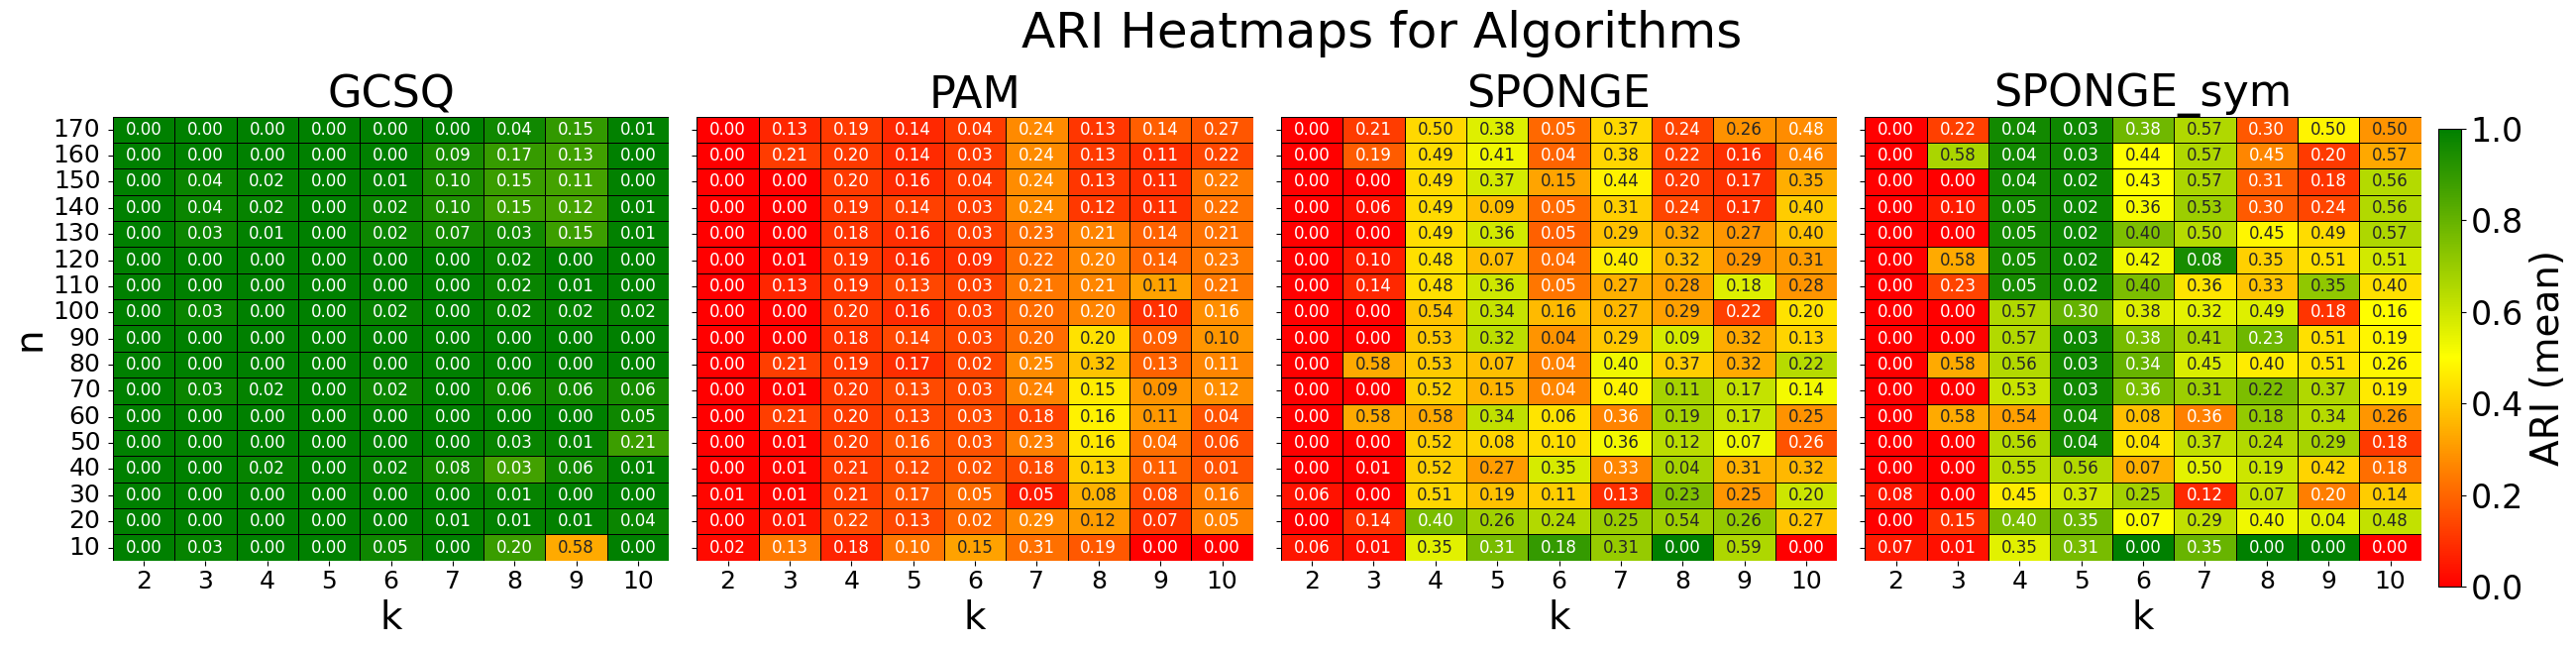

In [ ]:
algos = ["GCSQ", "PAM", "SPONGE", "SPONGE_sym"]
metrics = ["ARI"]
n_clusters_list = [2,3,4,5,6,7,8,9,10]

# Load your experiment results
df = pd.read_csv(f"report.csv")
df_filtered = df[df["n_clusters"] != 1]


plot_metric_heatmaps_column(df_filtered, "ARI", algos)